In [65]:
import os
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt
np.random.seed(1234)
tf.random.set_seed(1234)

### Redefining MLP class to include two hidden layers instead of one

In [66]:
# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden]))
    # Initialize weights between hidden layer and second hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for second hidden layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden]))
    # Initialize weights between second hidden layer and output
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden, self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation, using more weights and biases for 2 hidden layer
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.losses.mean_squared_error(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in first hidden layer
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.relu(what)
    
    #compute values in second hidden layer
    what = tf.matmul(hhat, self.W2) + self.b2
    hhat = tf.nn.relu(what)
    # Compute output
    output = tf.matmul(hhat, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return tf.nn.softmax(output)

### Loading fashion mnist database

In [75]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
image_vector_size = 28*28
x_train = x_train.reshape(x_train.shape[0], image_vector_size)
x_test = x_test.reshape(x_test.shape[0], image_vector_size)
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

### Loading hyperparameters

In [76]:
NUM_EPOCHS = 10

In [77]:
size_input = int(tf.shape(x_train)[1])
size_hidden = 256
size_output = int(tf.shape(y_train)[1])
number_of_train_examples = int(tf.shape(x_train)[0])
number_of_test_examples = int(tf.shape(x_test)[0])

### Training fashion mnist on MLP GPU device

Number of Epoch = 1 - Average MSE:= 0.17694052734375 - Train Accuracy:= 0.8229666948318481 - Test Accuracy:= 0.8241699934005737
Number of Epoch = 2 - Average MSE:= 0.17754119466145835 - Train Accuracy:= 0.8227641582489014 - Test Accuracy:= 0.8237450122833252
Number of Epoch = 3 - Average MSE:= 0.17734039713541666 - Train Accuracy:= 0.8224566578865051 - Test Accuracy:= 0.823306679725647
Number of Epoch = 4 - Average MSE:= 0.17805807291666667 - Train Accuracy:= 0.822374165058136 - Test Accuracy:= 0.8232275247573853
Number of Epoch = 5 - Average MSE:= 0.17764469401041666 - Train Accuracy:= 0.822339653968811 - Test Accuracy:= 0.8231340050697327
Number of Epoch = 6 - Average MSE:= 0.17782057291666667 - Train Accuracy:= 0.8222255706787109 - Test Accuracy:= 0.8229799866676331
Number of Epoch = 7 - Average MSE:= 0.1740369140625 - Train Accuracy:= 0.8227954506874084 - Test Accuracy:= 0.823505699634552
Number of Epoch = 8 - Average MSE:= 0.180413818359375 - Train Accuracy:= 0.8224443793296814 - 

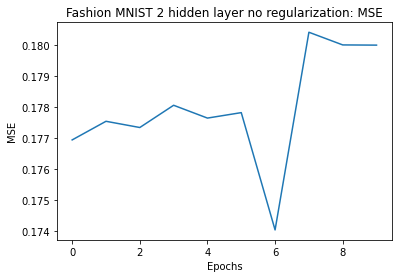

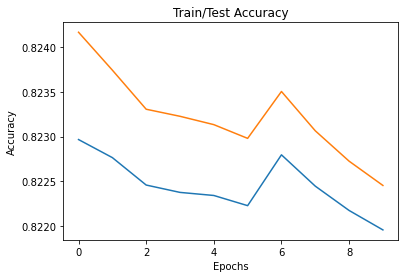

In [78]:
# Initialize regularized model using GPU 
mlp_on_gpu = MLP(size_input, size_hidden, size_output, device='gpu')
MSE = []
graph_epoch = []
time_start = time.time()    
train_acc = tf.keras.metrics.Accuracy()
test_acc = tf.keras.metrics.Accuracy()
train_list = []
test_list = []

for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=seed_num).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  train_acc.update_state(y_train, mlp_on_gpu.forward(x_train))
  test_acc.update_state(y_test, mlp_on_gpu.forward(x_test))
  MSE.append(np.sum(loss_total_gpu / x_train.shape[0]))
  print('Number of Epoch = {} - Average MSE:= {} - Train Accuracy:= {} - Test Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0], train_acc.result(), test_acc.result()))
  train_list.append(train_acc.result())
  test_list.append(test_acc.result())
for i in range(NUM_EPOCHS):
    graph_epoch.append(i)

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
plt.plot(graph_epoch,MSE, label = "MSE")
plt.title('Fashion MNIST 2 hidden layer no regularization: MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.plot(graph_epoch, train_list, label = "Train")
plt.plot(graph_epoch, test_list, label = "Test")
plt.title('Train/Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

#### large overfitting on default values with no regularization parameters (fashion)

### Loading digits mnist and reshaping, then loading into inputs

In [79]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
#reshaping and converting to one-hot encoding
image_vector_size = 28*28
x_train = x_train.reshape(x_train.shape[0], image_vector_size)
x_test = x_test.reshape(x_test.shape[0], image_vector_size)
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

size_input = int(tf.shape(x_train)[1])
size_hidden = 256
size_output = int(tf.shape(y_train)[1])
number_of_train_examples = int(tf.shape(x_train)[0])
number_of_test_examples = int(tf.shape(x_test)[0])

### Training digits mnist on MLP GPU device

Number of Epoch = 1 - Average MSE:= 0.18079454752604165 - Train Accuracy:= 0.8195533156394958 - Test Accuracy:= 0.8200200200080872
Number of Epoch = 2 - Average MSE:= 0.18044820963541666 - Train Accuracy:= 0.8195533156394958 - Test Accuracy:= 0.8200200200080872
Number of Epoch = 3 - Average MSE:= 0.18044820963541666 - Train Accuracy:= 0.8195533156394958 - Test Accuracy:= 0.8200200200080872
Number of Epoch = 4 - Average MSE:= 0.18044820963541666 - Train Accuracy:= 0.8195533156394958 - Test Accuracy:= 0.8200200200080872
Number of Epoch = 5 - Average MSE:= 0.18044820963541666 - Train Accuracy:= 0.8195533156394958 - Test Accuracy:= 0.8200200200080872
Number of Epoch = 6 - Average MSE:= 0.18044820963541666 - Train Accuracy:= 0.8195533156394958 - Test Accuracy:= 0.8200200200080872
Number of Epoch = 7 - Average MSE:= 0.18044820963541666 - Train Accuracy:= 0.8195533156394958 - Test Accuracy:= 0.8200200200080872
Number of Epoch = 8 - Average MSE:= 0.18044820963541666 - Train Accuracy:= 0.819553

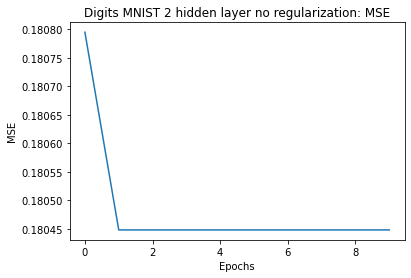

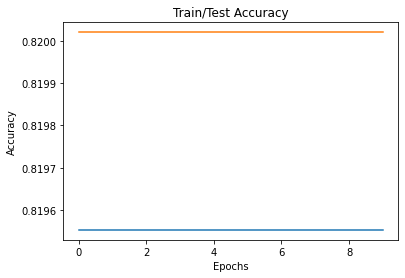

In [80]:
# Initialize regularized model using GPU 
mlp_on_gpu = MLP(size_input, size_hidden, size_output, device='gpu')
MSE = []
graph_epoch = []
time_start = time.time()    
train_acc = tf.keras.metrics.Accuracy()
test_acc = tf.keras.metrics.Accuracy()
train_list = []
test_list = []

for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=seed_num).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  train_acc.update_state(y_train, mlp_on_gpu.forward(x_train))
  test_acc.update_state(y_test, mlp_on_gpu.forward(x_test))
  MSE.append(np.sum(loss_total_gpu / x_train.shape[0]))
  print('Number of Epoch = {} - Average MSE:= {} - Train Accuracy:= {} - Test Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0], train_acc.result(), test_acc.result()))
  train_list.append(train_acc.result())
  test_list.append(test_acc.result())
for i in range(NUM_EPOCHS):
    graph_epoch.append(i)

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
plt.plot(graph_epoch,MSE, label = "MSE")
plt.title('Digits MNIST 2 hidden layer no regularization: MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.plot(graph_epoch, train_list, label = "Train")
plt.plot(graph_epoch, test_list, label = "Test")
plt.title('Train/Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

#### extreme overfitting on default values with no regularization parameters (digits)

### Redefining MLP class to include dropout layers after 

In [85]:
# Define class to build mlp model
class MLP_regularized(object):
  def __init__(self, size_input, size_hidden, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.device =\
    size_input, size_hidden, size_output, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden]))
    # Initialize weights between hidden layer and second hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for second hidden layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden]))
    # Initialize weights between second hidden layer and output
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden, self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation, using more weights and biases for 2 hidden layer
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.losses.mean_squared_error(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in first hidden layer
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.relu(what)
    #adding dropout layer to first hidden layer
    hhat = tf.nn.dropout(hhat, rate = 0, seed= 1234)
    
    #compute values in second hidden layer
    what = tf.matmul(hhat, self.W2) + self.b2
    hhat = tf.nn.relu(what)
    #adding dropout layer to second hidden layer
    hhat = tf.nn.dropout(hhat, rate = 0, seed = 1234)
    # Compute output
    output = tf.matmul(hhat, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return tf.nn.softmax(output)

### Normalizing MNIST data

In [86]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
#reshaping
image_vector_size = 28*28
x_train = x_train.reshape(x_train.shape[0], image_vector_size)
x_test = x_test.reshape(x_test.shape[0], image_vector_size)

#normalizing the data
x_train = x_train/255
x_test = x_test/255

#convert to one-hot encoding
num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

#loading into input sizes
size_input = int(tf.shape(x_train)[1])
size_hidden = 256
size_output = int(tf.shape(y_train)[1])
number_of_train_examples = int(tf.shape(x_train)[0])
number_of_test_examples = int(tf.shape(x_test)[0])

Number of Epoch = 1 - Average MSE:= 0.171189306640625 - Train Accuracy:= 0.8227949738502502 - Test Accuracy:= 0.8218399882316589
Number of Epoch = 2 - Average MSE:= 0.16506336263020832 - Train Accuracy:= 0.8245025277137756 - Test Accuracy:= 0.8240200281143188
Number of Epoch = 3 - Average MSE:= 0.162633154296875 - Train Accuracy:= 0.8255783319473267 - Test Accuracy:= 0.8253099918365479
Number of Epoch = 4 - Average MSE:= 0.16100890299479168 - Train Accuracy:= 0.8265050053596497 - Test Accuracy:= 0.8260625004768372
Number of Epoch = 5 - Average MSE:= 0.15703538411458334 - Train Accuracy:= 0.8278676867485046 - Test Accuracy:= 0.82737797498703
Number of Epoch = 6 - Average MSE:= 0.1540875 - Train Accuracy:= 0.8291519284248352 - Test Accuracy:= 0.8286333084106445
Number of Epoch = 7 - Average MSE:= 0.15261466471354165 - Train Accuracy:= 0.830281674861908 - Test Accuracy:= 0.8297842741012573
Number of Epoch = 8 - Average MSE:= 0.15216363932291666 - Train Accuracy:= 0.8312539458274841 - Test

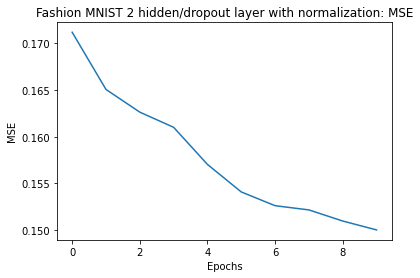

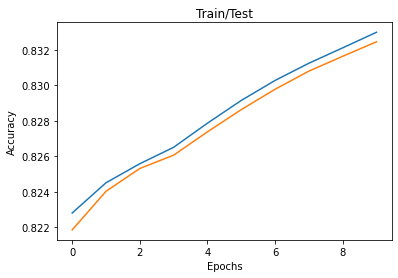

In [87]:
# Initialize regularized model using GPU 
mlp_on_gpu = MLP_regularized(size_input, size_hidden, size_output, device='gpu')
MSE = []
graph_epoch = []
time_start = time.time()    
train_acc = tf.keras.metrics.Accuracy()
test_acc = tf.keras.metrics.Accuracy()
train_list = []
test_list = []

for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=seed_num).batch(20)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  train_acc.update_state(y_train, mlp_on_gpu.forward(x_train))
  test_acc.update_state(y_test, mlp_on_gpu.forward(x_test))
  MSE.append(np.sum(loss_total_gpu / x_train.shape[0]))
  print('Number of Epoch = {} - Average MSE:= {} - Train Accuracy:= {} - Test Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0], train_acc.result(), test_acc.result()))
  train_list.append(train_acc.result())
  test_list.append(test_acc.result())
for i in range(NUM_EPOCHS):
    graph_epoch.append(i)

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
plt.plot(graph_epoch,MSE, label = "MSE")
plt.title('Fashion MNIST 2 hidden/dropout layer with normalization: MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.plot(graph_epoch, train_list, label = "Train")
plt.plot(graph_epoch, test_list, label = "Test")
plt.title('Train/Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

#### much less overfitting of data, very balanced training, much lower MSE

### Hyperparameter optimization

### Defining hyperparameters to optimize (epochs, batch size, seed, hidden layer size, dropout rate)

In [88]:
NUM_EPOCHS = 0
BATCH = 0
SEED = 0
size_hidden = 0
dropout_num = 0

In [89]:
# Define class to build mlp model
class MLP_regularized(object):
  def __init__(self, size_input, size_hidden, size_output,  dropout_num, seed_num, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_hidden, self.size_output, self.dropout_num, self.seed_num, self.device,  =\
    size_input, size_hidden, size_output, dropout_num, seed_num, device
    
    # Initialize weights between input layer and hidden layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden]))
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_hidden]))
    # Initialize weights between hidden layer and second hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden, self.size_hidden]))
    # Initialize biases for second hidden layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_hidden]))
    # Initialize weights between second hidden layer and output
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden, self.size_output]))
    # Initialize biases for output layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation, using more weights and biases for 2 hidden layer
    self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.losses.mean_squared_error(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    # Compute values in first hidden layer
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.relu(what)
    #adding dropout layer to first hidden layer
    hhat = tf.nn.dropout(hhat, rate = dropout_num, seed=seed_num)
    
    #compute values in second hidden layer
    what = tf.matmul(hhat, self.W2) + self.b2
    hhat = tf.nn.relu(what)
    #adding dropout layer to second hidden layer
    hhat = tf.nn.dropout(hhat, rate = dropout_num, seed = seed_num)
    # Compute output
    output = tf.matmul(hhat, self.W3) + self.b3
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return tf.nn.softmax(output)

### TRIAL 1 increased epochs to 20:

In [90]:
NUM_EPOCHS = 20
batch_num = 20
seed_num = 1234
size_hidden = 256
dropout_num = 0

Number of Epoch = 1 - Average MSE:= 0.18080699869791667 - Train Accuracy:= 0.8077200055122375 - Test Accuracy:= 0.8079299926757812
Number of Epoch = 2 - Average MSE:= 0.17808292643229168 - Train Accuracy:= 0.8096683621406555 - Test Accuracy:= 0.8095200061798096
Number of Epoch = 3 - Average MSE:= 0.1749076171875 - Train Accuracy:= 0.8112855553627014 - Test Accuracy:= 0.8113499879837036
Number of Epoch = 4 - Average MSE:= 0.173660205078125 - Train Accuracy:= 0.8125691413879395 - Test Accuracy:= 0.8126749992370605
Number of Epoch = 5 - Average MSE:= 0.17251520182291666 - Train Accuracy:= 0.8135376572608948 - Test Accuracy:= 0.8136619925498962
Number of Epoch = 6 - Average MSE:= 0.1717294921875 - Train Accuracy:= 0.8143091797828674 - Test Accuracy:= 0.814454972743988
Number of Epoch = 7 - Average MSE:= 0.17108387044270834 - Train Accuracy:= 0.8150126338005066 - Test Accuracy:= 0.8151585459709167
Number of Epoch = 8 - Average MSE:= 0.16979666341145833 - Train Accuracy:= 0.8155843615531921 

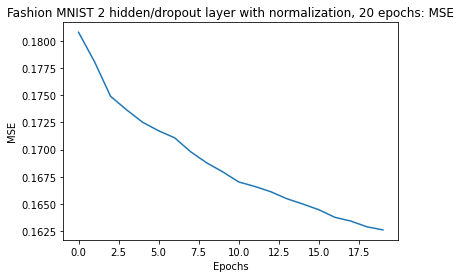

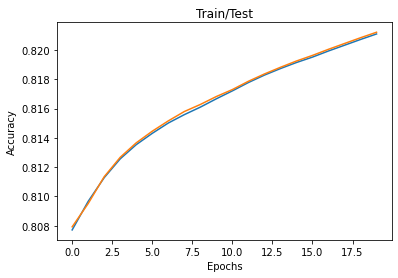

In [91]:
# Initialize regularized model using GPU 
mlp_on_gpu = MLP_regularized(size_input, size_hidden, size_output, dropout_num, seed_num, device='gpu')
MSE = []
graph_epoch = []
time_start = time.time()    
train_acc = tf.keras.metrics.Accuracy()
test_acc = tf.keras.metrics.Accuracy()
train_list = []
test_list = []

for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=seed_num).batch(batch_num)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  train_acc.update_state(y_train, mlp_on_gpu.forward(x_train))
  test_acc.update_state(y_test, mlp_on_gpu.forward(x_test))
  MSE.append(np.sum(loss_total_gpu / x_train.shape[0]))
  print('Number of Epoch = {} - Average MSE:= {} - Train Accuracy:= {} - Test Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0], train_acc.result(), test_acc.result()))
  train_list.append(train_acc.result())
  test_list.append(test_acc.result())
for i in range(NUM_EPOCHS):
    graph_epoch.append(i)

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
plt.plot(graph_epoch,MSE, label = "MSE")
plt.title('Fashion MNIST 2 hidden/dropout layer with normalization, 20 epochs: MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.plot(graph_epoch, train_list, label = "Train")
plt.plot(graph_epoch, test_list, label = "Test")
plt.title('Train/Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### TRIAL 2 increased batch size to 120:

In [92]:
NUM_EPOCHS = 20
batch_num = 120
seed_num = 1234
size_hidden = 256
dropout_num = 0

Number of Epoch = 1 - Average MSE:= 0.17177703450520834 - Train Accuracy:= 0.816433310508728 - Test Accuracy:= 0.8169100284576416
Number of Epoch = 2 - Average MSE:= 0.17124847005208332 - Train Accuracy:= 0.8170216679573059 - Test Accuracy:= 0.8171949982643127
Number of Epoch = 3 - Average MSE:= 0.17025611979166666 - Train Accuracy:= 0.8173850178718567 - Test Accuracy:= 0.8176766633987427
Number of Epoch = 4 - Average MSE:= 0.16947786458333333 - Train Accuracy:= 0.817526638507843 - Test Accuracy:= 0.8179975152015686
Number of Epoch = 5 - Average MSE:= 0.16878834635416667 - Train Accuracy:= 0.8177986741065979 - Test Accuracy:= 0.8182539939880371
Number of Epoch = 6 - Average MSE:= 0.16799365234375 - Train Accuracy:= 0.818055272102356 - Test Accuracy:= 0.8185566663742065
Number of Epoch = 7 - Average MSE:= 0.16675074869791667 - Train Accuracy:= 0.8183161616325378 - Test Accuracy:= 0.8187599778175354
Number of Epoch = 8 - Average MSE:= 0.16572268880208332 - Train Accuracy:= 0.818665623664

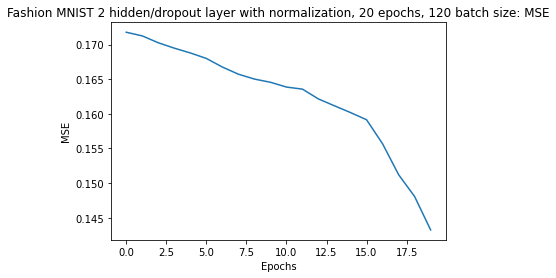

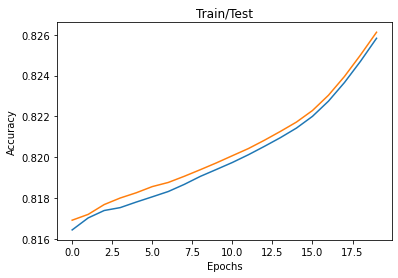

In [93]:
# Initialize regularized model using GPU 
mlp_on_gpu = MLP_regularized(size_input, size_hidden, size_output, dropout_num, seed_num, device='gpu')
MSE = []
graph_epoch = []
time_start = time.time()    
train_acc = tf.keras.metrics.Accuracy()
test_acc = tf.keras.metrics.Accuracy()
train_list = []
test_list = []

for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=seed_num).batch(batch_num)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  train_acc.update_state(y_train, mlp_on_gpu.forward(x_train))
  test_acc.update_state(y_test, mlp_on_gpu.forward(x_test))
  MSE.append(np.sum(loss_total_gpu / x_train.shape[0]))
  print('Number of Epoch = {} - Average MSE:= {} - Train Accuracy:= {} - Test Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0], train_acc.result(), test_acc.result()))
  train_list.append(train_acc.result())
  test_list.append(test_acc.result())
for i in range(NUM_EPOCHS):
    graph_epoch.append(i)

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
plt.plot(graph_epoch,MSE, label = "MSE")
plt.title('Fashion MNIST 2 hidden/dropout layer with normalization, 20 epochs, 120 batch size: MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.plot(graph_epoch, train_list, label = "Train")
plt.plot(graph_epoch, test_list, label = "Test")
plt.title('Train/Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### TRIAL 3 increased batch size to 500, epochs to 40:

In [98]:
NUM_EPOCHS = 40
batch_num = 500
seed_num = 1234
size_hidden = 256
dropout_num = 0

Number of Epoch = 1 - Average MSE:= 0.168807421875 - Train Accuracy:= 0.8243799805641174 - Test Accuracy:= 0.823889970779419
Number of Epoch = 2 - Average MSE:= 0.16612692057291667 - Train Accuracy:= 0.8251116871833801 - Test Accuracy:= 0.8246849775314331
Number of Epoch = 3 - Average MSE:= 0.16406761067708334 - Train Accuracy:= 0.8260260820388794 - Test Accuracy:= 0.8253133296966553
Number of Epoch = 4 - Average MSE:= 0.16129422200520832 - Train Accuracy:= 0.8273812532424927 - Test Accuracy:= 0.826449990272522
Number of Epoch = 5 - Average MSE:= 0.15626739908854168 - Train Accuracy:= 0.8289446830749512 - Test Accuracy:= 0.8278220295906067
Number of Epoch = 6 - Average MSE:= 0.15279853515625 - Train Accuracy:= 0.8304902911186218 - Test Accuracy:= 0.8294233083724976
Number of Epoch = 7 - Average MSE:= 0.15082496744791668 - Train Accuracy:= 0.8317504525184631 - Test Accuracy:= 0.8307114243507385
Number of Epoch = 8 - Average MSE:= 0.14954485677083335 - Train Accuracy:= 0.8329069018363953

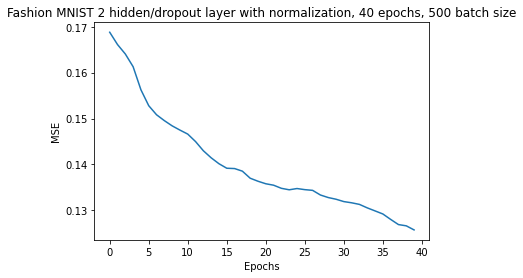

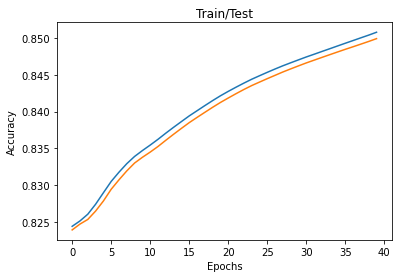

In [99]:
# Initialize regularized model using GPU 
mlp_on_gpu = MLP_regularized(size_input, size_hidden, size_output, dropout_num, seed_num, device='gpu')
MSE = []
graph_epoch = []
time_start = time.time()    
train_acc = tf.keras.metrics.Accuracy()
test_acc = tf.keras.metrics.Accuracy()
train_list = []
test_list = []

for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=seed_num).batch(batch_num)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  train_acc.update_state(y_train, mlp_on_gpu.forward(x_train))
  test_acc.update_state(y_test, mlp_on_gpu.forward(x_test))
  MSE.append(np.sum(loss_total_gpu / x_train.shape[0]))
  print('Number of Epoch = {} - Average MSE:= {} - Train Accuracy:= {} - Test Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0], train_acc.result(), test_acc.result()))
  train_list.append(train_acc.result())
  test_list.append(test_acc.result())
for i in range(NUM_EPOCHS):
    graph_epoch.append(i)

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
plt.plot(graph_epoch,MSE, label = "MSE")
plt.title('Fashion MNIST 2 hidden/dropout layer with normalization, 40 epochs, 500 batch size')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.plot(graph_epoch, train_list, label = "Train")
plt.plot(graph_epoch, test_list, label = "Test")
plt.title('Train/Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### TRIAL 4 raised dropout rate to 0.5:

In [100]:
NUM_EPOCHS = 40
batch_num = 500
seed_num = 1234
size_hidden = 256
dropout_num = 0.5

Number of Epoch = 1 - Average MSE:= 0.180423828125 - Train Accuracy:= 0.814976692199707 - Test Accuracy:= 0.8146899938583374
Number of Epoch = 2 - Average MSE:= 0.18079069010416668 - Train Accuracy:= 0.814817488193512 - Test Accuracy:= 0.8147150278091431
Number of Epoch = 3 - Average MSE:= 0.18027000325520834 - Train Accuracy:= 0.8148722052574158 - Test Accuracy:= 0.8147533535957336
Number of Epoch = 4 - Average MSE:= 0.18011162109375 - Train Accuracy:= 0.8148074746131897 - Test Accuracy:= 0.8147075176239014
Number of Epoch = 5 - Average MSE:= 0.180208642578125 - Train Accuracy:= 0.8148840069770813 - Test Accuracy:= 0.814873993396759
Number of Epoch = 6 - Average MSE:= 0.17975185546875 - Train Accuracy:= 0.8148519396781921 - Test Accuracy:= 0.8147416710853577
Number of Epoch = 7 - Average MSE:= 0.18024182942708333 - Train Accuracy:= 0.8149109482765198 - Test Accuracy:= 0.814668595790863
Number of Epoch = 8 - Average MSE:= 0.17975768229166667 - Train Accuracy:= 0.8149093985557556 - Test

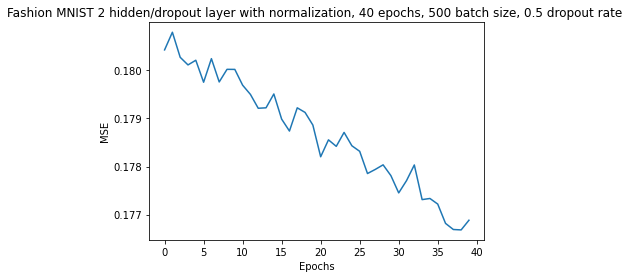

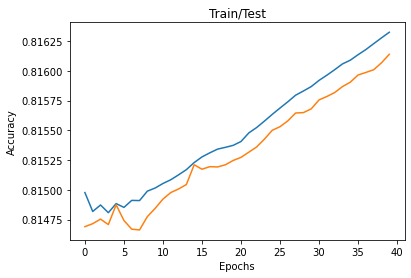

In [101]:
# Initialize regularized model using GPU 
mlp_on_gpu = MLP_regularized(size_input, size_hidden, size_output, dropout_num, seed_num, device='gpu')
MSE = []
graph_epoch = []
time_start = time.time()    
train_acc = tf.keras.metrics.Accuracy()
test_acc = tf.keras.metrics.Accuracy()
train_list = []
test_list = []

for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=seed_num).batch(batch_num)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  train_acc.update_state(y_train, mlp_on_gpu.forward(x_train))
  test_acc.update_state(y_test, mlp_on_gpu.forward(x_test))
  MSE.append(np.sum(loss_total_gpu / x_train.shape[0]))
  print('Number of Epoch = {} - Average MSE:= {} - Train Accuracy:= {} - Test Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0], train_acc.result(), test_acc.result()))
  train_list.append(train_acc.result())
  test_list.append(test_acc.result())
for i in range(NUM_EPOCHS):
    graph_epoch.append(i)

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
plt.plot(graph_epoch,MSE, label = "MSE")
plt.title('Fashion MNIST 2 hidden/dropout layer with normalization, 40 epochs, 500 batch size, 0.5 dropout rate ')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.plot(graph_epoch, train_list, label = "Train")
plt.plot(graph_epoch, test_list, label = "Test")
plt.title('Train/Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### TRIAL 5 dropout rate dropped to 0.3, increased epochs to 60

In [102]:
NUM_EPOCHS = 60
batch_num = 500
seed_num = 1234
size_hidden = 256
dropout_num = 0.3

Number of Epoch = 1 - Average MSE:= 0.18037561848958333 - Train Accuracy:= 0.8115249872207642 - Test Accuracy:= 0.8116000294685364
Number of Epoch = 2 - Average MSE:= 0.18005126953125 - Train Accuracy:= 0.8117275238037109 - Test Accuracy:= 0.8118900060653687
Number of Epoch = 3 - Average MSE:= 0.17966380208333332 - Train Accuracy:= 0.8120477795600891 - Test Accuracy:= 0.8121366500854492
Number of Epoch = 4 - Average MSE:= 0.17921608072916667 - Train Accuracy:= 0.812166690826416 - Test Accuracy:= 0.812345027923584
Number of Epoch = 5 - Average MSE:= 0.17933885091145832 - Train Accuracy:= 0.8122973442077637 - Test Accuracy:= 0.8125839829444885
Number of Epoch = 6 - Average MSE:= 0.178465234375 - Train Accuracy:= 0.8124011158943176 - Test Accuracy:= 0.8126933574676514
Number of Epoch = 7 - Average MSE:= 0.1788728515625 - Train Accuracy:= 0.8125954866409302 - Test Accuracy:= 0.8128742575645447
Number of Epoch = 8 - Average MSE:= 0.1782544921875 - Train Accuracy:= 0.8127670884132385 - Test 

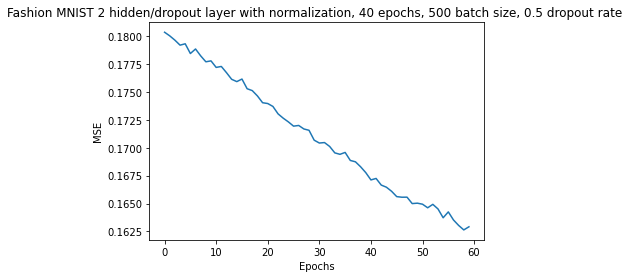

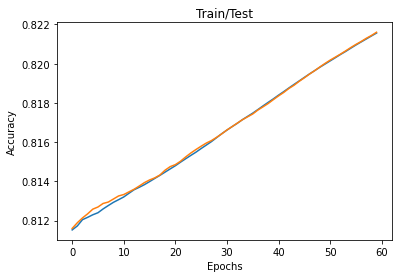

In [103]:
# Initialize regularized model using GPU 
mlp_on_gpu = MLP_regularized(size_input, size_hidden, size_output, dropout_num, seed_num, device='gpu')
MSE = []
graph_epoch = []
time_start = time.time()    
train_acc = tf.keras.metrics.Accuracy()
test_acc = tf.keras.metrics.Accuracy()
train_list = []
test_list = []

for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=seed_num).batch(batch_num)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  train_acc.update_state(y_train, mlp_on_gpu.forward(x_train))
  test_acc.update_state(y_test, mlp_on_gpu.forward(x_test))
  MSE.append(np.sum(loss_total_gpu / x_train.shape[0]))
  print('Number of Epoch = {} - Average MSE:= {} - Train Accuracy:= {} - Test Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0], train_acc.result(), test_acc.result()))
  train_list.append(train_acc.result())
  test_list.append(test_acc.result())
for i in range(NUM_EPOCHS):
    graph_epoch.append(i)

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
plt.plot(graph_epoch,MSE, label = "MSE")
plt.title('Fashion MNIST 2 hidden/dropout layer with normalization, 40 epochs, 500 batch size, 0.5 dropout rate ')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.plot(graph_epoch, train_list, label = "Train")
plt.plot(graph_epoch, test_list, label = "Test")
plt.title('Train/Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### TRIAL 6 dropout rate dropped to 0, increased hidden size to 512

In [104]:
NUM_EPOCHS = 60
batch_num = 500
seed_num = 1234
size_hidden = 512
dropout_num = 0

Number of Epoch = 1 - Average MSE:= 0.177728173828125 - Train Accuracy:= 0.8173766732215881 - Test Accuracy:= 0.8170999884605408
Number of Epoch = 2 - Average MSE:= 0.17565916341145835 - Train Accuracy:= 0.818322479724884 - Test Accuracy:= 0.8188250064849854
Number of Epoch = 3 - Average MSE:= 0.174208984375 - Train Accuracy:= 0.8194922208786011 - Test Accuracy:= 0.8199466466903687
Number of Epoch = 4 - Average MSE:= 0.17247552083333334 - Train Accuracy:= 0.8205166459083557 - Test Accuracy:= 0.8207774758338928
Number of Epoch = 5 - Average MSE:= 0.16960291341145833 - Train Accuracy:= 0.8216233253479004 - Test Accuracy:= 0.8217499852180481
Number of Epoch = 6 - Average MSE:= 0.16542337239583332 - Train Accuracy:= 0.8231966495513916 - Test Accuracy:= 0.8233516812324524
Number of Epoch = 7 - Average MSE:= 0.162736474609375 - Train Accuracy:= 0.8244100213050842 - Test Accuracy:= 0.8245757222175598
Number of Epoch = 8 - Average MSE:= 0.16197692057291666 - Train Accuracy:= 0.8255108594894409

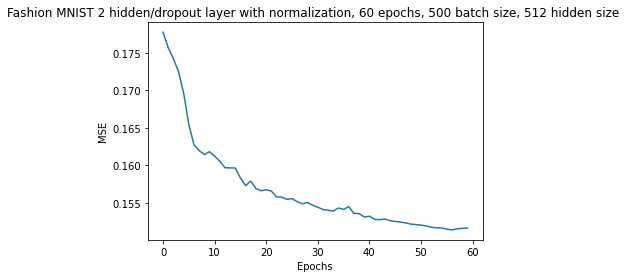

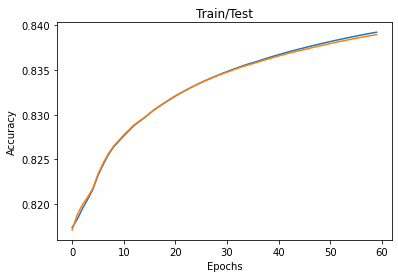

In [105]:
# Initialize regularized model using GPU 
mlp_on_gpu = MLP_regularized(size_input, size_hidden, size_output, dropout_num, seed_num, device='gpu')
MSE = []
graph_epoch = []
time_start = time.time()    
train_acc = tf.keras.metrics.Accuracy()
test_acc = tf.keras.metrics.Accuracy()
train_list = []
test_list = []

for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=seed_num).batch(batch_num)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  train_acc.update_state(y_train, mlp_on_gpu.forward(x_train))
  test_acc.update_state(y_test, mlp_on_gpu.forward(x_test))
  MSE.append(np.sum(loss_total_gpu / x_train.shape[0]))
  print('Number of Epoch = {} - Average MSE:= {} - Train Accuracy:= {} - Test Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0], train_acc.result(), test_acc.result()))
  train_list.append(train_acc.result())
  test_list.append(test_acc.result())
for i in range(NUM_EPOCHS):
    graph_epoch.append(i)

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
plt.plot(graph_epoch,MSE, label = "MSE")
plt.title('Fashion MNIST 2 hidden/dropout layer with normalization, 60 epochs, 500 batch size, 512 hidden size ')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.plot(graph_epoch, train_list, label = "Train")
plt.plot(graph_epoch, test_list, label = "Test")
plt.title('Train/Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### TRIAL 7 decreased hidden size to 128

In [106]:
NUM_EPOCHS = 60
batch_num = 500
seed_num = 1234
size_hidden = 128
dropout_num = 0

Number of Epoch = 1 - Average MSE:= 0.17950595703125 - Train Accuracy:= 0.811073362827301 - Test Accuracy:= 0.8119800090789795
Number of Epoch = 2 - Average MSE:= 0.17924161783854167 - Train Accuracy:= 0.8111583590507507 - Test Accuracy:= 0.8120899796485901
Number of Epoch = 3 - Average MSE:= 0.1789521484375 - Train Accuracy:= 0.8112044334411621 - Test Accuracy:= 0.8120566606521606
Number of Epoch = 4 - Average MSE:= 0.17875270182291667 - Train Accuracy:= 0.8112258315086365 - Test Accuracy:= 0.8119699954986572
Number of Epoch = 5 - Average MSE:= 0.17840079752604165 - Train Accuracy:= 0.811120331287384 - Test Accuracy:= 0.8118860125541687
Number of Epoch = 6 - Average MSE:= 0.17779143880208334 - Train Accuracy:= 0.8110155463218689 - Test Accuracy:= 0.8118083477020264
Number of Epoch = 7 - Average MSE:= 0.17583816731770832 - Train Accuracy:= 0.8110561966896057 - Test Accuracy:= 0.8117914199829102
Number of Epoch = 8 - Average MSE:= 0.17137496744791667 - Train Accuracy:= 0.811489999294281

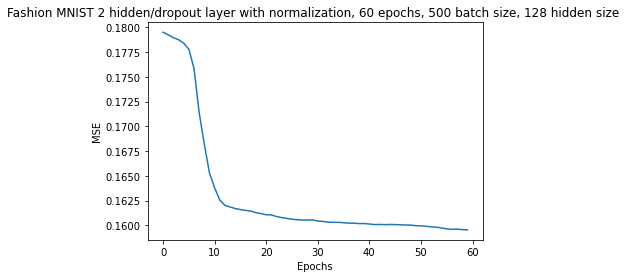

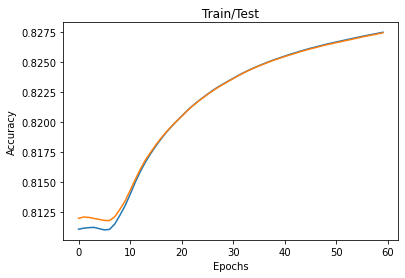

In [107]:
# Initialize regularized model using GPU 
mlp_on_gpu = MLP_regularized(size_input, size_hidden, size_output, dropout_num, seed_num, device='gpu')
MSE = []
graph_epoch = []
time_start = time.time()    
train_acc = tf.keras.metrics.Accuracy()
test_acc = tf.keras.metrics.Accuracy()
train_list = []
test_list = []

for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=seed_num).batch(batch_num)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  train_acc.update_state(y_train, mlp_on_gpu.forward(x_train))
  test_acc.update_state(y_test, mlp_on_gpu.forward(x_test))
  MSE.append(np.sum(loss_total_gpu / x_train.shape[0]))
  print('Number of Epoch = {} - Average MSE:= {} - Train Accuracy:= {} - Test Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0], train_acc.result(), test_acc.result()))
  train_list.append(train_acc.result())
  test_list.append(test_acc.result())
for i in range(NUM_EPOCHS):
    graph_epoch.append(i)

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
plt.plot(graph_epoch,MSE, label = "MSE")
plt.title('Fashion MNIST 2 hidden/dropout layer with normalization, 60 epochs, 500 batch size, 128 hidden size ')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.plot(graph_epoch, train_list, label = "Train")
plt.plot(graph_epoch, test_list, label = "Test")
plt.title('Train/Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### TRIAL 8 brought back hidden size to 256, raised batch size to 750

In [108]:
NUM_EPOCHS = 60
batch_num = 750
seed_num = 1234
size_hidden = 256
dropout_num = 0

Number of Epoch = 1 - Average MSE:= 0.17466183268229166 - Train Accuracy:= 0.8150733113288879 - Test Accuracy:= 0.8155400156974792
Number of Epoch = 2 - Average MSE:= 0.17304886067708333 - Train Accuracy:= 0.8164183497428894 - Test Accuracy:= 0.8167399764060974
Number of Epoch = 3 - Average MSE:= 0.17166559244791665 - Train Accuracy:= 0.8176149725914001 - Test Accuracy:= 0.8177933096885681
Number of Epoch = 4 - Average MSE:= 0.17043352864583333 - Train Accuracy:= 0.8184987306594849 - Test Accuracy:= 0.8185275197029114
Number of Epoch = 5 - Average MSE:= 0.16794943033854168 - Train Accuracy:= 0.8192786574363708 - Test Accuracy:= 0.8191919922828674
Number of Epoch = 6 - Average MSE:= 0.1648416015625 - Train Accuracy:= 0.8202961087226868 - Test Accuracy:= 0.8201649785041809
Number of Epoch = 7 - Average MSE:= 0.16232906901041666 - Train Accuracy:= 0.8214185833930969 - Test Accuracy:= 0.8212943077087402
Number of Epoch = 8 - Average MSE:= 0.16080921223958333 - Train Accuracy:= 0.8224470615

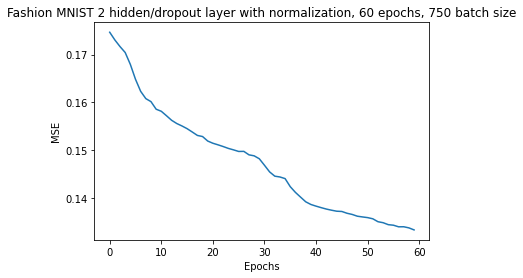

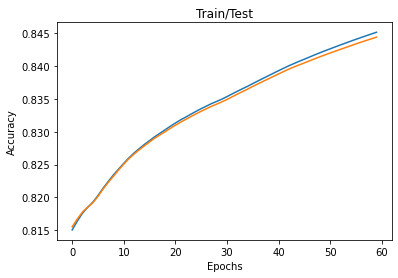

In [109]:
# Initialize regularized model using GPU 
mlp_on_gpu = MLP_regularized(size_input, size_hidden, size_output, dropout_num, seed_num, device='gpu')
MSE = []
graph_epoch = []
time_start = time.time()    
train_acc = tf.keras.metrics.Accuracy()
test_acc = tf.keras.metrics.Accuracy()
train_list = []
test_list = []

for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=seed_num).batch(batch_num)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  train_acc.update_state(y_train, mlp_on_gpu.forward(x_train))
  test_acc.update_state(y_test, mlp_on_gpu.forward(x_test))
  MSE.append(np.sum(loss_total_gpu / x_train.shape[0]))
  print('Number of Epoch = {} - Average MSE:= {} - Train Accuracy:= {} - Test Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0], train_acc.result(), test_acc.result()))
  train_list.append(train_acc.result())
  test_list.append(test_acc.result())
for i in range(NUM_EPOCHS):
    graph_epoch.append(i)

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
plt.plot(graph_epoch,MSE, label = "MSE")
plt.title('Fashion MNIST 2 hidden/dropout layer with normalization, 60 epochs, 750 batch size')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.plot(graph_epoch, train_list, label = "Train")
plt.plot(graph_epoch, test_list, label = "Test")
plt.title('Train/Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### TRIAL 9 Batch size dropped to 400, epochs raised to 100

In [110]:
NUM_EPOCHS = 100
batch_num = 400
seed_num = 1234
size_hidden = 256
dropout_num = 0

Number of Epoch = 1 - Average MSE:= 0.16953063151041667 - Train Accuracy:= 0.8212783336639404 - Test Accuracy:= 0.8209999799728394
Number of Epoch = 2 - Average MSE:= 0.16559073893229168 - Train Accuracy:= 0.8230875134468079 - Test Accuracy:= 0.822475016117096
Number of Epoch = 3 - Average MSE:= 0.16390576171875 - Train Accuracy:= 0.8236227631568909 - Test Accuracy:= 0.8228933215141296
Number of Epoch = 4 - Average MSE:= 0.16223567708333334 - Train Accuracy:= 0.8247295618057251 - Test Accuracy:= 0.8238250017166138
Number of Epoch = 5 - Average MSE:= 0.16004850260416667 - Train Accuracy:= 0.8258659839630127 - Test Accuracy:= 0.8250060081481934
Number of Epoch = 6 - Average MSE:= 0.15849972330729167 - Train Accuracy:= 0.826603353023529 - Test Accuracy:= 0.8257333040237427
Number of Epoch = 7 - Average MSE:= 0.157125830078125 - Train Accuracy:= 0.827620267868042 - Test Accuracy:= 0.8266528844833374
Number of Epoch = 8 - Average MSE:= 0.15634202473958334 - Train Accuracy:= 0.82845747470855

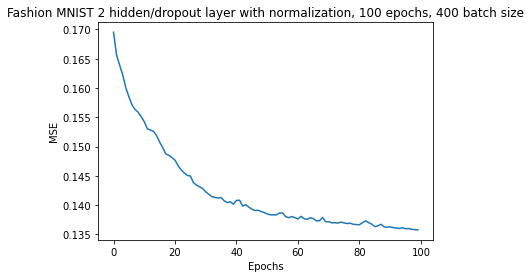

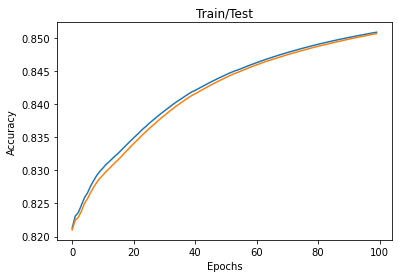

In [112]:
# Initialize regularized model using GPU 
mlp_on_gpu = MLP_regularized(size_input, size_hidden, size_output, dropout_num, seed_num, device='gpu')
MSE = []
graph_epoch = []
time_start = time.time()    
train_acc = tf.keras.metrics.Accuracy()
test_acc = tf.keras.metrics.Accuracy()
train_list = []
test_list = []

for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=seed_num).batch(batch_num)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  train_acc.update_state(y_train, mlp_on_gpu.forward(x_train))
  test_acc.update_state(y_test, mlp_on_gpu.forward(x_test))
  MSE.append(np.sum(loss_total_gpu / x_train.shape[0]))
  print('Number of Epoch = {} - Average MSE:= {} - Train Accuracy:= {} - Test Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0], train_acc.result(), test_acc.result()))
  train_list.append(train_acc.result())
  test_list.append(test_acc.result())
for i in range(NUM_EPOCHS):
    graph_epoch.append(i)

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
plt.plot(graph_epoch,MSE, label = "MSE")
plt.title('Fashion MNIST 2 hidden/dropout layer with normalization, 100 epochs, 400 batch size')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.plot(graph_epoch, train_list, label = "Train")
plt.plot(graph_epoch, test_list, label = "Test")
plt.title('Train/Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### TRIAL 10: Batch size dropped to 100

In [113]:
NUM_EPOCHS = 100
batch_num = 100
seed_num = 1234
size_hidden = 256
dropout_num = 0

Number of Epoch = 1 - Average MSE:= 0.17520681966145835 - Train Accuracy:= 0.820068359375 - Test Accuracy:= 0.8193600177764893
Number of Epoch = 2 - Average MSE:= 0.17416886393229167 - Train Accuracy:= 0.8204533457756042 - Test Accuracy:= 0.8197799921035767
Number of Epoch = 3 - Average MSE:= 0.173001171875 - Train Accuracy:= 0.8210083246231079 - Test Accuracy:= 0.8204766511917114
Number of Epoch = 4 - Average MSE:= 0.17146002604166666 - Train Accuracy:= 0.8215125203132629 - Test Accuracy:= 0.8210600018501282
Number of Epoch = 5 - Average MSE:= 0.16980011393229166 - Train Accuracy:= 0.8222950100898743 - Test Accuracy:= 0.8218420147895813
Number of Epoch = 6 - Average MSE:= 0.166787646484375 - Train Accuracy:= 0.8232952952384949 - Test Accuracy:= 0.8227816820144653
Number of Epoch = 7 - Average MSE:= 0.16355613606770833 - Train Accuracy:= 0.8244507312774658 - Test Accuracy:= 0.82386714220047
Number of Epoch = 8 - Average MSE:= 0.16023468424479168 - Train Accuracy:= 0.8256518840789795 - 

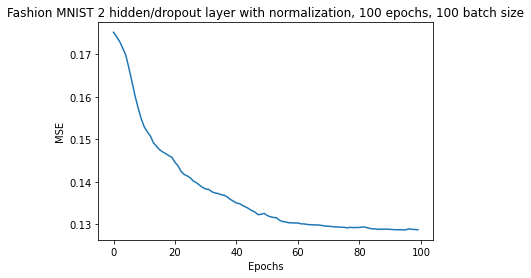

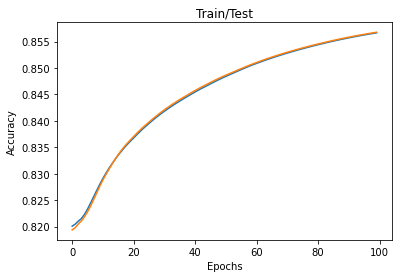

In [114]:
# Initialize regularized model using GPU 
mlp_on_gpu = MLP_regularized(size_input, size_hidden, size_output, dropout_num, seed_num, device='gpu')
MSE = []
graph_epoch = []
time_start = time.time()    
train_acc = tf.keras.metrics.Accuracy()
test_acc = tf.keras.metrics.Accuracy()
train_list = []
test_list = []

for epoch in range(NUM_EPOCHS):
  loss_total_gpu = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(25, seed=seed_num).batch(batch_num)
  for inputs, outputs in train_ds:
    preds = mlp_on_gpu.forward(inputs)
    loss_total_gpu = loss_total_gpu + mlp_on_gpu.loss(preds, outputs)
    lt = lt + mlp_on_gpu.loss(preds, outputs)
    mlp_on_gpu.backward(inputs, outputs)
  train_acc.update_state(y_train, mlp_on_gpu.forward(x_train))
  test_acc.update_state(y_test, mlp_on_gpu.forward(x_test))
  MSE.append(np.sum(loss_total_gpu / x_train.shape[0]))
  print('Number of Epoch = {} - Average MSE:= {} - Train Accuracy:= {} - Test Accuracy:= {}'.format(epoch + 1, np.sum(loss_total_gpu) / x_train.shape[0], train_acc.result(), test_acc.result()))
  train_list.append(train_acc.result())
  test_list.append(test_acc.result())
for i in range(NUM_EPOCHS):
    graph_epoch.append(i)

time_taken = time.time() - time_start

print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
plt.plot(graph_epoch,MSE, label = "MSE")
plt.title('Fashion MNIST 2 hidden/dropout layer with normalization, 100 epochs, 100 batch size')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()
plt.plot(graph_epoch, train_list, label = "Train")
plt.plot(graph_epoch, test_list, label = "Test")
plt.title('Train/Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

### FINAL PARAMETERS:

#### Epochs: 100
#### Batch Size: 100
#### Dropout size: 0
#### Hidden size: 256

#### These will produce the highest accuracy results with the least amount of overfitting/underfitting according to my testing